In [1]:
# 检查你的Python版本
from sys import version_info
if version_info.major != 2 and version_info.minor != 7:
    raise Exception('请使用Python 2.7来完成此项目')

In [2]:
# 引入这个项目需要的库
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display # 使得我们可以对DataFrame使用display()函数
import xgboost as xgb
from time import time

# 设置以内联的形式显示matplotlib绘制的图片（在notebook中显示更美观）
%matplotlib inline

# 载入客户数据集
try:
    df_train = pd.read_csv("train.csv")
    df_store = pd.read_csv("store.csv")
except:
    print "Dataset could not be loaded. Is the dataset missing?"

/home/bairui/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
df_train.head()

In [3]:
# 显示train特征
df_train.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
# 引入datetime,并且对date特征进行分割
import datetime
sales_raw = df_train["Sales"]
df_train['Year']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').year)
df_train['Month']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').month)
df_train['Day']=df_train['Date'].apply(lambda x:datetime.datetime.strptime(x,'%Y-%m-%d').day)

#将Date特征移除
features_raw = df_train.drop("Date",axis = 1)

#将所有数据进行one-hot编码
features_raw = pd.get_dummies(features_raw)

#将Stateholiday_0特征移除(在特征中没有效果)
features_raw=features_raw.drop("StateHoliday_0",axis = 1)

In [5]:
#预览feature_raw
features_raw.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,StateHoliday_a,StateHoliday_b,StateHoliday_c
0,1,5,5263,555,1,1,1,2015,7,31,0,0,0
1,2,5,6064,625,1,1,1,2015,7,31,0,0,0
2,3,5,8314,821,1,1,1,2015,7,31,0,0,0
3,4,5,13995,1498,1,1,1,2015,7,31,0,0,0
4,5,5,4822,559,1,1,1,2015,7,31,0,0,0


In [6]:
# 将store数据集进行one-hot编码
store_etc= pd.get_dummies(df_store)

# 显示store特征
store_etc.head()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
0,1,1270.0,9.0,2008.0,0,NaN,NaN,0,0,1,0,1,0,0,0,0,0
1,2,570.0,11.0,2007.0,1,13.0,2010.0,1,0,0,0,1,0,0,0,1,0
2,3,14130.0,12.0,2006.0,1,14.0,2011.0,1,0,0,0,1,0,0,0,1,0
3,4,620.0,9.0,2009.0,0,NaN,NaN,0,0,1,0,0,0,1,0,0,0
4,5,29910.0,4.0,2015.0,0,NaN,NaN,1,0,0,0,1,0,0,0,0,0


In [7]:
# 对store数据集查找缺省值
store_etc.isnull().sum()

Store                               0
CompetitionDistance                 3
CompetitionOpenSinceMonth         354
CompetitionOpenSinceYear          354
Promo2                              0
Promo2SinceWeek                   544
Promo2SinceYear                   544
StoreType_a                         0
StoreType_b                         0
StoreType_c                         0
StoreType_d                         0
Assortment_a                        0
Assortment_b                        0
Assortment_c                        0
PromoInterval_Feb,May,Aug,Nov       0
PromoInterval_Jan,Apr,Jul,Oct       0
PromoInterval_Mar,Jun,Sept,Dec      0
dtype: int64

In [8]:
# 查看Competition Distance特征中的缺省值
store_etc[pd.isnull(store_etc.CompetitionDistance)]

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,StoreType_a,StoreType_b,StoreType_c,StoreType_d,Assortment_a,Assortment_b,Assortment_c,"PromoInterval_Feb,May,Aug,Nov","PromoInterval_Jan,Apr,Jul,Oct","PromoInterval_Mar,Jun,Sept,Dec"
290,291,NaN,NaN,NaN,0,NaN,NaN,0,0,0,1,1,0,0,0,0,0
621,622,NaN,NaN,NaN,0,NaN,NaN,1,0,0,0,0,0,1,0,0,0
878,879,NaN,NaN,NaN,1,5.0,2013.0,0,0,0,1,1,0,0,1,0,0


In [9]:
# 填充缺省值为median平均值
store_etc['CompetitionDistance'].fillna(store_etc['CompetitionDistance'].median(), inplace = True)

In [10]:
# 将训练集分割出35天作为测试集
test_data = features_raw[:39025]
train_data = features_raw[39025:]
train_data.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday,Year,Month,Day,StateHoliday_a,StateHoliday_b,StateHoliday_c
39025,1,5,3317,420,1,0,0,2015,6,26,0,0,0
39026,2,5,3953,476,1,0,0,2015,6,26,0,0,0
39027,3,5,6222,698,1,0,0,2015,6,26,0,0,0
39028,4,5,7684,1076,1,0,0,2015,6,26,0,0,0
39029,5,5,3799,460,1,0,0,2015,6,26,0,0,0


In [11]:
train_store=pd.merge(features_raw, df_store, how = 'inner', on = 'Store')
train_store['SalePerCustomer'] = features_raw['Sales']/features_raw['Customers']
train_store.groupby('DayOfWeek')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
DayOfWeek,,,,,,,,
1,144730.0,7809.044510,4016.526273,0.0,5235.00,7310.0,9972.0,41551.0
2,145664.0,7005.244467,3142.039607,0.0,4904.00,6463.0,8491.0,34692.0
3,145665.0,6555.884138,2944.377501,0.0,4718.00,6133.0,7926.0,33151.0
4,145845.0,6247.575913,3209.806360,0.0,4536.00,6020.0,7792.0,38367.0
5,145845.0,6723.274305,3101.006008,0.0,4975.00,6434.0,8206.0,38722.0
6,144730.0,5847.562599,2873.985615,0.0,3899.25,5410.0,7220.0,31683.0
7,144730.0,204.183189,1613.243517,0.0,0.00,0.0,0.0,37376.0


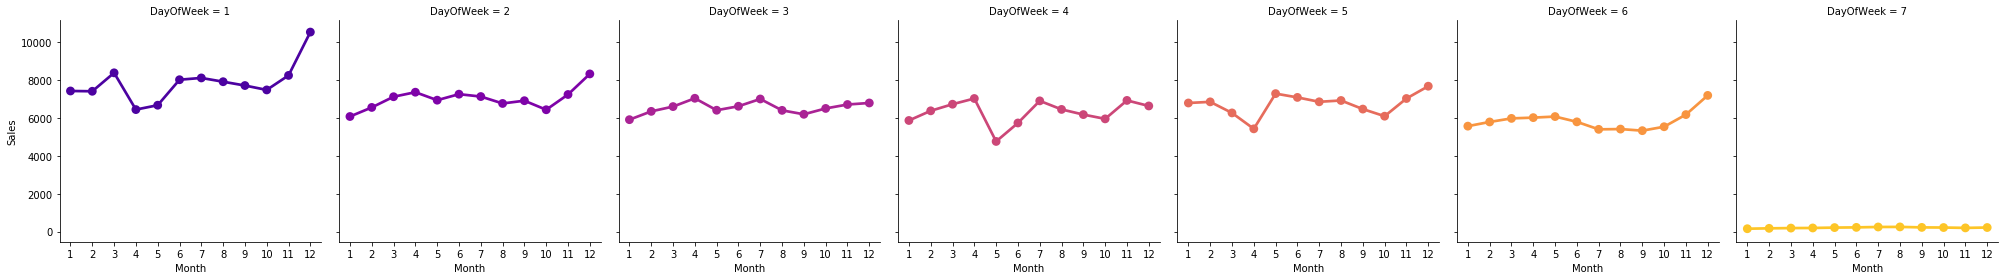

In [12]:
# 销售额均值-按星期几排序
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'DayOfWeek', 
               palette = 'plasma',
               hue = 'DayOfWeek') 

In [13]:
train_store['SalePerCustomer'].describe()

count    844340.000000
mean          9.493619
std           2.197494
min           0.000000
25%           7.895563
50%           9.250000
75%          10.899729
max          64.957854
Name: SalePerCustomer, dtype: float64

In [14]:
train_store.groupby('Month')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Month,,,,,,,,
1,103694.0,5465.395529,3572.685233,0.0,3577.00,5483.0,7464.0,32263.0
2,93660.0,5645.253150,3519.990270,0.0,3837.00,5610.0,7516.0,31649.0
3,103695.0,5784.578871,3871.175081,0.0,3705.00,5750.0,7885.0,36227.0
4,100350.0,5738.866916,3940.456503,0.0,3604.25,5718.0,7944.0,38722.0
5,103695.0,5489.639973,3983.233069,0.0,2941.50,5717.0,7827.0,38484.0
6,100350.0,5760.964375,3909.373300,0.0,3697.00,5729.0,7865.0,41551.0
7,98115.0,6064.915711,3640.947610,0.0,4151.00,5953.0,8009.0,32671.0
8,63550.0,5693.016554,3556.992585,0.0,3815.00,5633.0,7606.0,33913.0
9,61500.0,5570.246033,3542.059830,0.0,3731.00,5504.0,7445.0,32926.0


In [15]:
# 各类型门店有几个
from collections import Counter
c = Counter(df_store['StoreType'])
print c

Counter({'a': 602, 'd': 348, 'c': 148, 'b': 17})


In [16]:
# 销售额-按月份
train_store.groupby('StoreType')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
StoreType,,,,,,,,
a,551627.0,5738.179710,3964.028134,0.0,3508.0,5618.0,7860.00,41551.0
b,15830.0,10058.837334,5280.525506,0.0,6227.0,9025.5,13082.75,38722.0
c,136840.0,5723.629246,3721.700886,0.0,3789.0,5766.0,7849.00,31448.0
d,312912.0,5641.819243,3473.393781,0.0,3986.0,5826.0,7691.00,38037.0


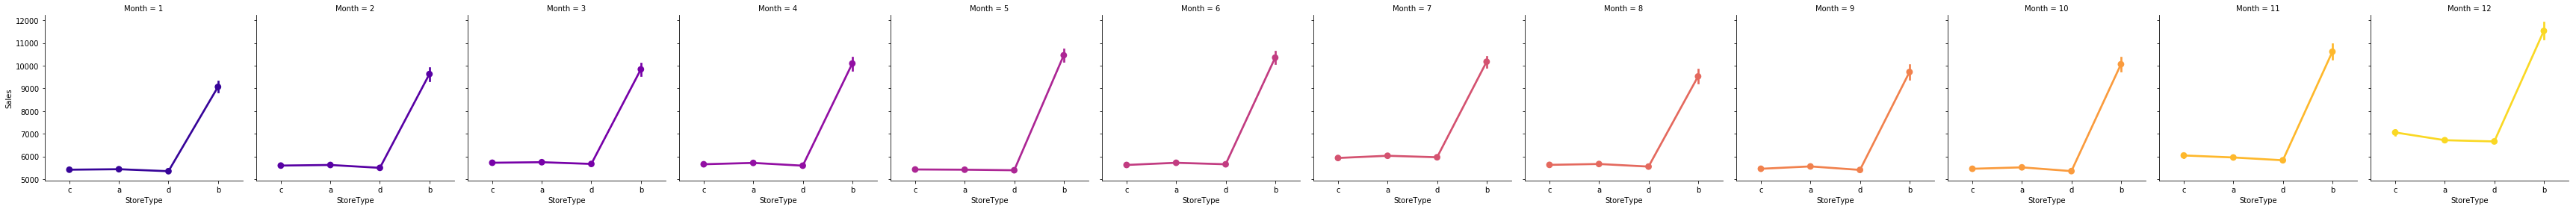

In [17]:
# 销售额-按月份
sns.factorplot(data = train_store, x = 'StoreType', y = "Sales", 
               col = 'Month', 
               palette = 'plasma',
               hue = 'Month') 

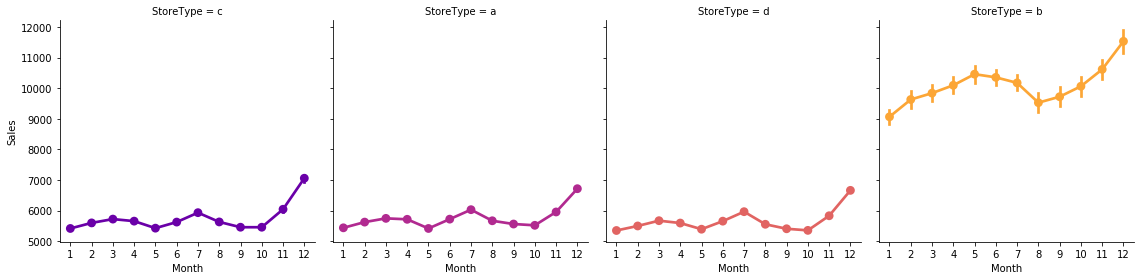

In [18]:
# 销售额-按店类型
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType') 

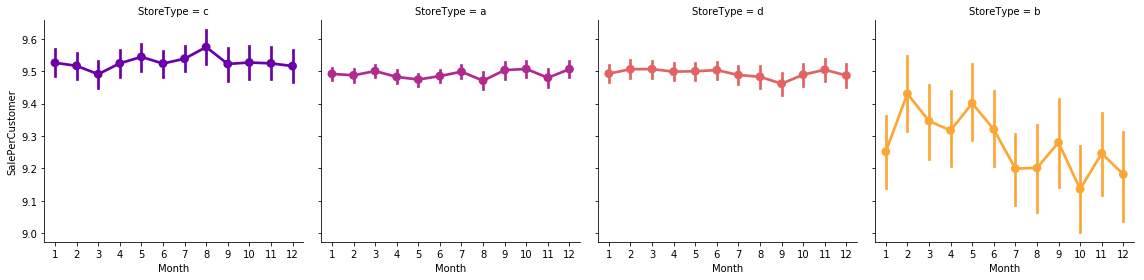

In [19]:
# 单人消费额度-按店类型
sns.factorplot(data = train_store, x = 'Month', y = "SalePerCustomer", 
               col = 'StoreType', # per store type in cols
               palette = 'plasma',
               hue = 'StoreType') 

In [20]:
train_store.groupby('Promo')['Sales'].describe()

,count,mean,std,min,25%,50%,75%,max
Promo,,,,,,,,
0,629129.0,4406.050805,3442.450020,0.0,0.0,4622.0,6367.0,41551.0
1,388080.0,7991.152046,3419.025495,0.0,5922.0,7553.0,9603.0,38722.0


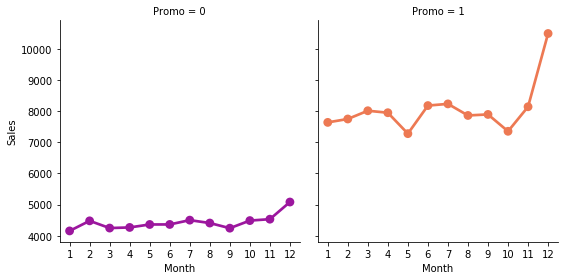

In [21]:
# 销售额均值-对比有无促销(Promo)
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               palette = 'plasma',
               hue = 'Promo',
               ) 

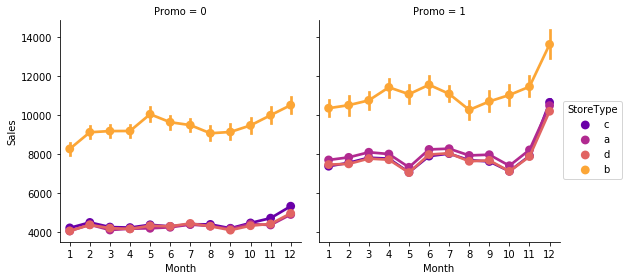

In [22]:
# 销售额均值-对比有无促销(Promo)
sns.factorplot(data = train_store, x = 'Month', y = "Sales", 
               col = 'Promo', 
               palette = 'plasma',
               hue = 'StoreType') 

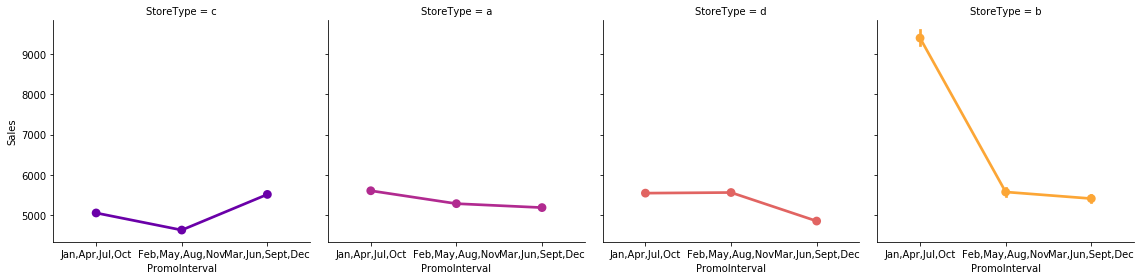

In [23]:
# 各门店销售额均值-按促销时间段
sns.factorplot(data = train_store, x = 'PromoInterval', y = "Sales", 
               col = 'StoreType', 
               palette = 'plasma',
               hue = 'StoreType') 

In [24]:
#对测试集和训练集分别features和object的区分
X_train = pd.merge(train_data, store_etc, how = 'inner', on = 'Store').drop('Sales',axis=1)
Y_train = pd.merge(train_data, store_etc, how = 'inner', on = 'Store')['Sales']
X_test = pd.merge(test_data, store_etc, how = 'inner', on = 'Store').drop('Sales',axis=1)
Y_test = pd.merge(test_data, store_etc, how = 'inner', on = 'Store')['Sales']

In [25]:
# 导入 train_test_split
from sklearn.model_selection import train_test_split
# 将'X_train'和'y_train'进一步切分为训练集和验证集
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=0)

In [27]:
#该评价指标用来评价模型好坏  
def rmspe(real,predict):  
    #对训练集分出的Y_Val数列化
    real=list(real)
    #sum_value
    sum_value=0.0  
    # count_num作为非零计数,在此指标中,假如真实Y为零,计算会出现错误,所以排除真实销售为零的干扰
    count_num=0
    for i in range(len(real)):
        if real[i] == 0:
            continue
        else:
            v1=((real[i]-predict[i])/real[i])**2  
            sum_value += v1
            count_num += 1
    v2=sum_value / count_num
    v3=np.sqrt(v2)
    return v3  

In [30]:
dtrain=xgb.DMatrix(train_data, label=None, missing=None, weight=None, silent=False, feature_names=None, feature_types=None, nthread=None)

In [28]:
def train_predict(model, sample_size, X_train, y_train, X_val, y_val): 
    '''
    inputs:
       - model: 模型
       - sample_size: sample大小
       - X_train: 训练集特征
       - Y_train: 训练集的销售额
       - X_val: 验证集特征
       - Y_val: 验证集的销售额
    '''
    
    results = {}
    
    # TODO：使用sample_size大小的训练数据来拟合模型
    start = time() # 获得程序开始时间
    model = model.fit(X_train[:sample_size],y_train[:sample_size])
    end = time() # 获得程序结束时间
    
    # TODO：计算训练时间
    results['train_time'] = end-start
    
    # TODO: 得到在验证集上的预测值
    start = time() # 获得程序开始时间
    predictions_val = model.predict(X_val)
    end = time() # 获得程序结束时间
    
    # TODO：计算预测用时
    results['pred_time'] = end-start
               
    # TODO：计算验证集上的rmspe-score
    results['RMSPE'] = rmspe(Y_val,predictions_val)
       
    # 成功
    print "{} 训练了{} 个samples.".format(model.__class__.__name__, sample_size)
        
    # 返回结果
    return results

In [29]:
# 载入xgboost
model = xgb.XGBRegressor(booster='gbtree',learning_rate=0.001,max_depth=10,tree_method='gpu_hist',random_state=0,n_estimators=100,base_score=0.5)
# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = int(X_train.shape[0] * 1)
# 收集模型的结果
results = {}
for i in [samples_1, samples_10, samples_100]:
    results[i] = train_predict(model, i, X_train, Y_train, X_val, Y_val)
#     打印训练时间格式精确到小数点两位
    print "训练时间花费{:.2f}秒,预测时间花费为{:.2f}秒,RMSPE值为{:.5f}".format(results[i]['train_time'],results[i]['pred_time'],results[i]['RMSPE'])

XGBRegressor 训练了7825 个samples.
训练时间花费1.45秒,预测时间花费为0.11秒,RMSPE值为0.90296
XGBRegressor 训练了78254 个samples.
训练时间花费2.69秒,预测时间花费为0.11秒,RMSPE值为0.90298
XGBRegressor 训练了782547 个samples.
训练时间花费11.80秒,预测时间花费为0.12秒,RMSPE值为0.90287


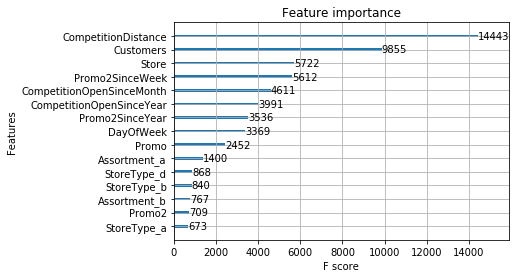

In [29]:
xgb.plot_importance(model,max_num_features=15)

In [30]:
predict_test = model.predict(X_test)
print rmspe(Y_test,predict_test)

0.912664487874


In [31]:
final_model = xgb.XGBRegressor(booster='gbtree',learning_rate=0.003,max_depth=10,tree_method='gpu_hist',random_state=0,n_estimators=180,base_score=0.5)
# TODO：计算1%， 10%， 100%的训练数据分别对应多少点
samples_1 = int(X_train.shape[0] * 0.01)
samples_10 = int(X_train.shape[0] * 0.1)
samples_100 = int(X_train.shape[0] * 1)
# 收集模型的结果
results = {}
for i in [samples_1, samples_10, samples_100]:
    results[i] = train_predict(final_model, i, X_train, Y_train, X_val, Y_val)
#     打印训练时间格式精确到小数点两位
    print "训练时间花费{:.2f}秒,预测时间花费为{:.2f}秒,RMSPE值为{:.5f}".format(results[i]['train_time'],results[i]['pred_time'],results[i]['RMSPE'])

XGBRegressor 训练了7825 个samples.
训练时间花费4.86秒,预测时间花费为0.25秒,RMSPE值为0.57905
XGBRegressor 训练了78254 个samples.
训练时间花费19.20秒,预测时间花费为0.27秒,RMSPE值为0.57778
XGBRegressor 训练了782547 个samples.
训练时间花费45.95秒,预测时间花费为0.26秒,RMSPE值为0.57681


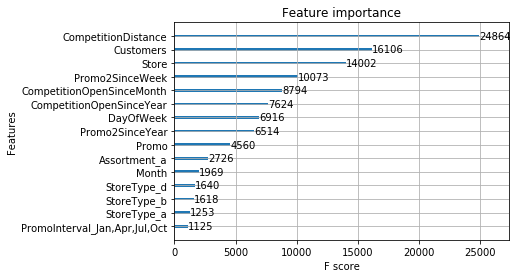

In [32]:
xgb.plot_importance(final_model,max_num_features=15)

In [33]:
predict_test = final_model.predict(X_test)
print rmspe(Y_test,predict_test)

0.692573615736
